# Example of generating a GVEC equilibrium

This example demonstrates how to:
- Create a GVEC equilibrium configuration using the GVEC library
- Visualize the geometry and profiles
- Export to GYSELA format (HDF5)

**Note**: This requires the `gvec` package to be installed. See https://github.com/gvec/gvec for installation instructions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gysmc import GvecMagnetConfig, CulhamMagnetConfig, QProfile, GYSMagnetConfig

# Check if GVEC is available
try:
    import gvec
    print("GVEC is available!")
except ImportError:
    print("WARNING: GVEC is not available. Please install it using:")
    print("  pip install gvec")
    print("or see https://github.com/gvec/gvec for installation instructions")


GVEC is available!


### Set up the GVEC equilibrium parameters ###

Two options are available:

a) Read from parameter file (VMEC or Gvec format)

b) pass parameters same as culham equilibria:

- **major_radius**: Major radius at magnetic axis (R0)
- **q_profile**: Safety factor profile (QProfile object or None for default)
- **pressure_profile**: Pressure profile (optional, can be array or object with get_pressure method)
- **rmax**: Maximum radial coordinate (should match GYSELA rmax)
- **beta_toro**: Toroidal beta parameter
- **kappa_elongation**: Elongation at edge
- **delta_triangularity**: Triangularity at edge
- **runpath**: Optional path for GVEC run directory (uses temporary directory if None)

Running GVEC with parameters dictionary...
GVEC finished after   5.5 seconds  using 6372 iterations (totalIter = 10000)  with |force| = 9.99e-07 (minimize_tol = 1.00e-06) 
GVEC run successful
GVEC equilibrium initialized successfully!


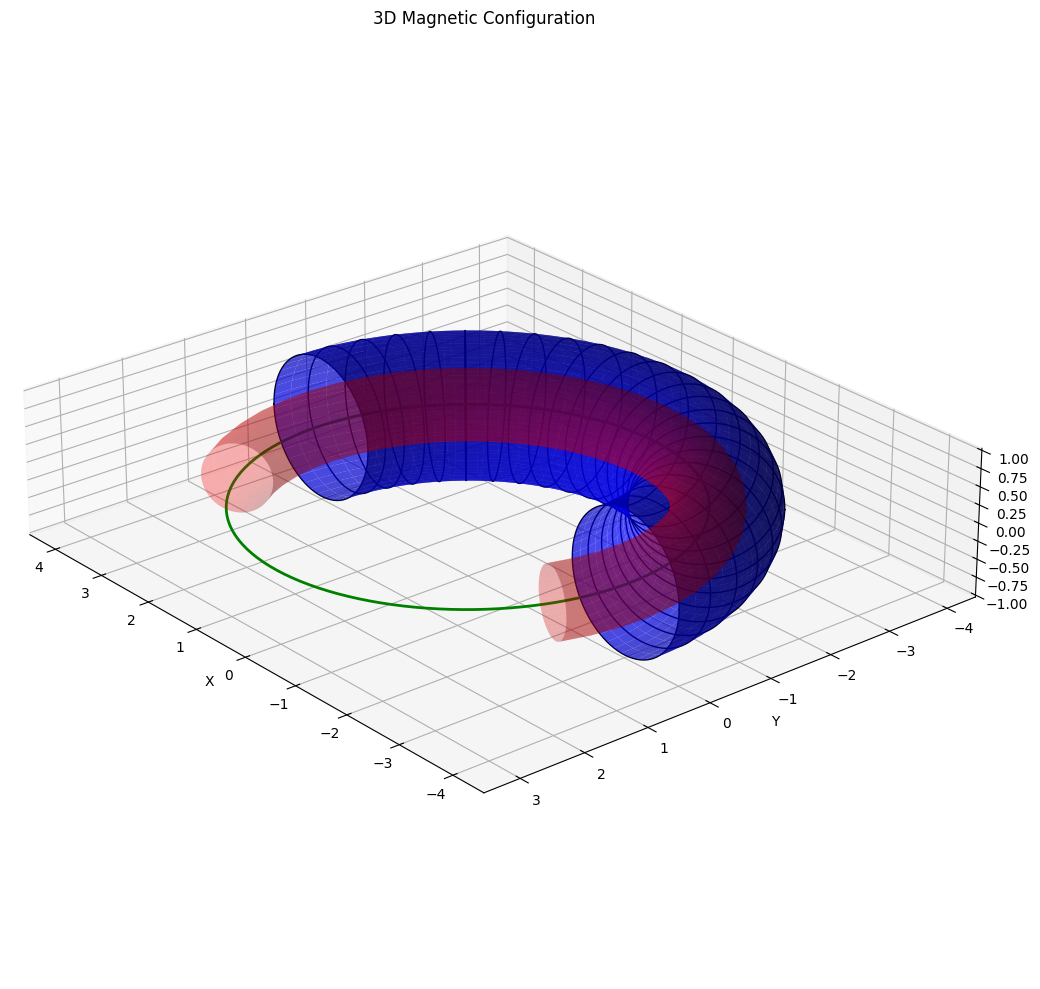

In [5]:
# Create a parabolic q profile: q(r) = q0 + qa * (r/a)^2
# Option 2: Parabolic profile
q_profile = QProfile(option=2, q_param1=1.0, q_param2=0, q_param3=0, rmax=1, number_radial_points=64)

# Initialize GVEC equilibrium
# Note: This will run GVEC equilibrium solver, which may take a few minutes
gvecmc = GvecMagnetConfig(
    major_radius=3.0,         # R0 = 3.0
    q_profile=q_profile,      # Safety factor profile
    pressure_profile=None,    # No pressure profile (beta=0)
    beta_toro=0.0,            # Toroidal beta
    kappa_elongation=1,      # Elongation kappa = 1.8
    delta_triangularity=0,  # Triangularity delta = 0.4
    runpath=None              # Use temporary directory
)

print("GVEC equilibrium initialized successfully!")

gvecmc.plot_3D()

### Visualize the equilibrium ###

We can plot the q profile and geometry to verify the equilibrium.

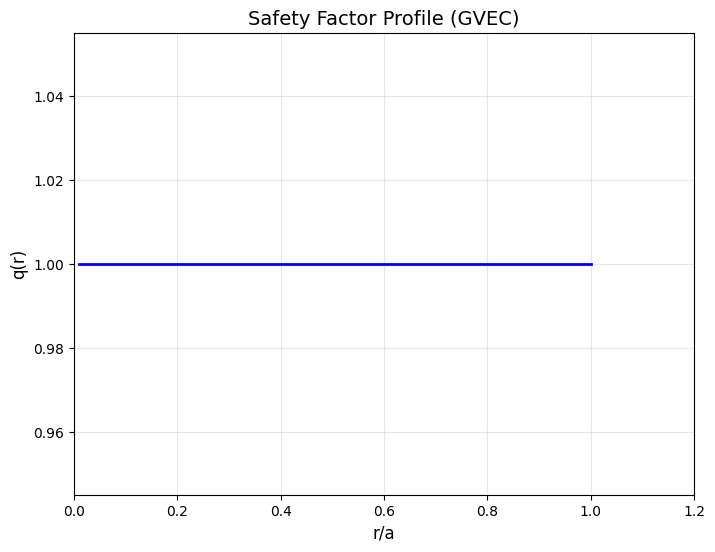

In [6]:
# Plot q profile
r_array = np.linspace(0.01, 1, 200)
q_values = gvecmc.get_q(r_array)

plt.figure(figsize=(8, 6))
plt.plot(r_array, q_values, 'b-', linewidth=2)
plt.xlabel('r/a', fontsize=12)
plt.ylabel('q(r)', fontsize=12)
plt.title('Safety Factor Profile (GVEC)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1.2)
plt.show()


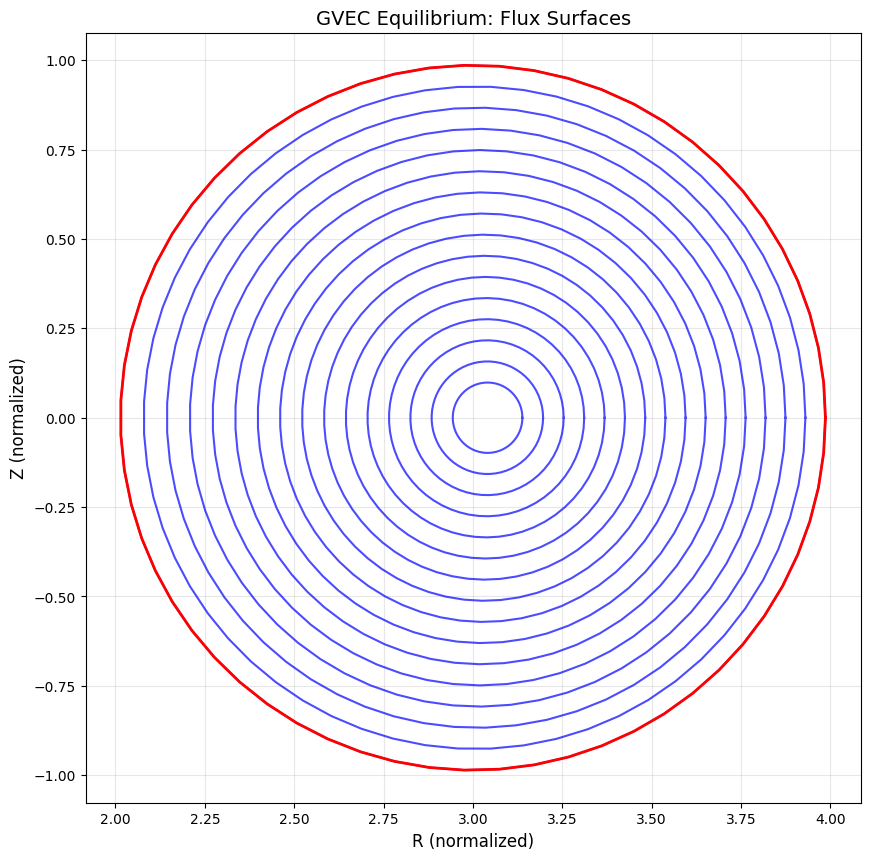

In [7]:
# Plot geometry (flux surfaces)
r_plot = np.linspace(0.1, 1, 16)
theta_plot = np.linspace(0, 2*np.pi, 64)
phi_plot = np.array([0.0])

R, Z = gvecmc.get_RZ(r_plot, theta_plot, phi_plot)

plt.figure(figsize=(10, 10))
for i in range(len(r_plot)):
    plt.plot(R[i, :, 0], Z[i, :, 0], 'b-', linewidth=1.5, alpha=0.7)

# Plot the last surface (edge) in red
plt.plot(R[-1, :, 0], Z[-1, :, 0], 'r-', linewidth=2)

plt.axis('equal')
plt.xlabel('R (normalized)', fontsize=12)
plt.ylabel('Z (normalized)', fontsize=12)
plt.title('GVEC Equilibrium: Flux Surfaces', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


### Write to GYSELA magnet_config.h5 ###

```Nr```, ```Ntheta```, ```minor_radius```, ```rmin```, ```rmax```, ```skiphole``` should match that of a GYSELA input file


### How to use the generated hdf5 ###

- Copy it to ```gysela``` folder under ```wk/profiles```.

- Set ```magnet_strategy = "EXTERNAL"``` in your ```EQUIL``` namelist.

- Specify the path to the hdf5 file such as ```magnet_config_filename = profiles/magnet_config.h5``` in the ```Variables for radial profile input files``` section.


### Compare to Culham ###



In [8]:
# Initialize Culham equilibrium with the same parameters
culhammc = CulhamMagnetConfig(
    major_radius=3.0,         # R0 = 3.0
    q_profile=q_profile,      # Safety factor profile (same as GVEC)
    pressure_profile=None,    # No pressure profile (beta=0)
    beta_toro=0.0,            # Toroidal beta
    Shafranov_shift=True,      # Shafranov shift
    kappa_elongation=1,      # Elongation kappa = 1.8
    delta_triangularity=0,  # Triangularity delta = 0.4
    rmax=1.0                  # Maximum radial coordinate
)

print("Culham equilibrium initialized successfully!")

Culham equilibrium initialized successfully!


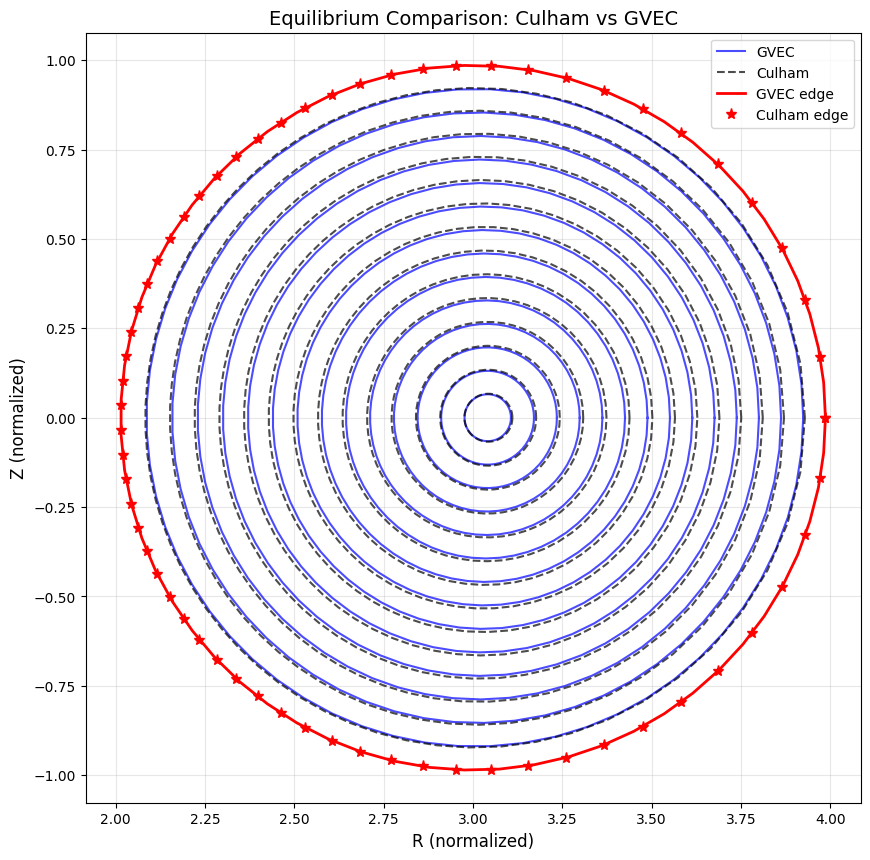

In [38]:
# plot profile comparison between Culham and GVEC
r_plot = np.linspace(1e-14,1 , 16)
theta_plot = np.linspace(0, 2*np.pi, 64)
phi_plot = np.array([0.0])

R_culham, Z_culham = culhammc.get_RZ(r_plot, theta_plot, phi_plot)
R_gvec, Z_gvec = gvecmc.get_RZ(r_plot, theta_plot, phi_plot)

plt.figure(figsize=(10, 10))
for i in range(len(r_plot)-1):
    plt.plot(R_gvec[i, :, 0], Z_gvec[i, :, 0], 'b-', linewidth=1.5, alpha=0.7, label='GVEC' if i == 0 else '')
    plt.plot(R_culham[i, :, 0], Z_culham[i, :, 0], 'k--', linewidth=1.5, alpha=0.7, label='Culham' if i == 0 else '')

# Plot the last surface (edge) in red
plt.plot(R_gvec[-1, :, 0], Z_gvec[-1, :, 0], 'r-', linewidth=2, label='GVEC edge')
plt.plot(R_culham[-1, :, 0], Z_culham[-1, :, 0], 'r*', linewidth=1, markersize=8, label='Culham edge')

plt.axis('equal')
plt.xlabel('R (normalized)', fontsize=12)
plt.ylabel('Z (normalized)', fontsize=12)
plt.title('Equilibrium Comparison: Culham vs GVEC', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.show()

### Stellarator Example ###

This example demonstrates how to create a stellarator equilibrium using GVEC with a 3D boundary shape.
Based on the [GVEC stellarator tutorial](https://gvec.readthedocs.io/latest/tutorials/notebooks/020_stellarator.html).


In [5]:
# Define stellarator parameters
# This creates a rotating ellipse boundary with 3 field periods
params_stellarator = {
    "ProjectName": "GVEC_ellipstell",
    # hmap to cylinder coordinates: X1=R, X2=Z, zeta=-phi
    "which_hmap": 1,
    # Fourier resolution parameters
    "X1_mn_max": [3, 3],  # maximum Fourier mode numbers for X1 [m:poloidal, n:toroidal]
    "X2_mn_max": [3, 3],  # maximum Fourier mode numbers for X2
    "LA_mn_max": [3, 3],  # maximum Fourier mode numbers for LA
    # number of field periods
    "nfp": 3,
    # (m,n) cosine Fourier mode coefficient for X1 (boundary)
    "X1_b_cos": {
        (0, 0): 3.0,
        (1, 0): 1.0,
        (1, 1): 0.4,
    },
    # (m,n) sine Fourier mode coefficient for X2 (boundary)
    "X2_b_sin": {
        (1, 0): 1.0,
        (1, 1): -0.4,
        (0, 1): -0.25,
    },
    # initial guess for magnetic axis is computed from the boundary shape
    "init_average_axis": True,
    # profile definitions for iota and pressure
    "PhiEdge": 1.0,  # total toroidal flux (scales magnetic field strength)
    "iota": {
        "type": "polynomial",
        "coefs": [0.625, 0.35],
    },
    "pres": {
        "type": "polynomial",
        "coefs": [1.0, -1.0],
        "scale": 1000.0,
    },
    # radial resolution parameters
    "sgrid_nElems": 2,  # number of radial B-spline elements
    "X1X2_deg": 5,  # degree of B-splines for X1 and X2
    "LA_deg": 5,  # degree of B-splines for LA
    # Minimizer parameters
    "totalIter": 10000,  # maximum number of iterations
    "minimize_tol": 1e-6,  # abort tolerance on sqrt(|forces|^2)
    "logIter": 100,  # log interval for diagnostics
}

# Initialize stellarator equilibrium using from_params
print("Initializing stellarator equilibrium...")
gvecmc_stellarator = GvecMagnetConfig.from_params(params_stellarator, runpath=None)
print("Stellarator equilibrium initialized successfully!")


Initializing stellarator equilibrium...
Running GVEC with parameters dictionary...
GVEC finished after  36.1 seconds  using 9800 iterations (totalIter = 10000)  with |force| = 1.00e-06 (minimize_tol = 1.00e-06) 
GVEC run successful
Stellarator equilibrium initialized successfully!


### Visualize Stellarator Cross Sections ###

Plot magnetic field strength |B| in multiple poloidal planes.


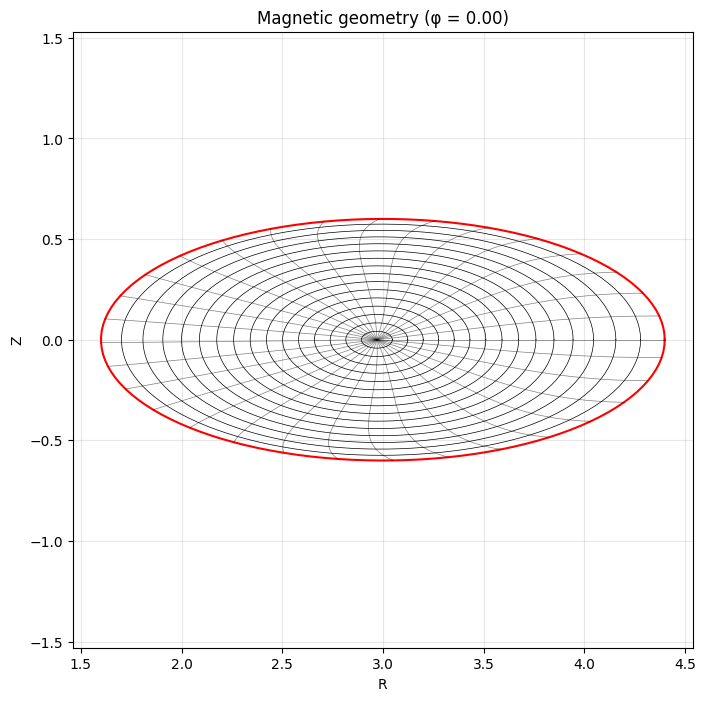

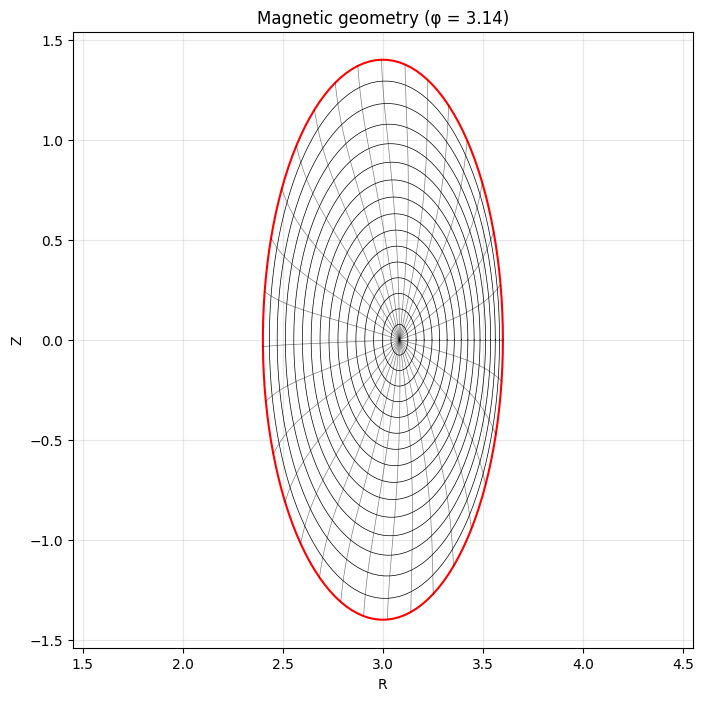

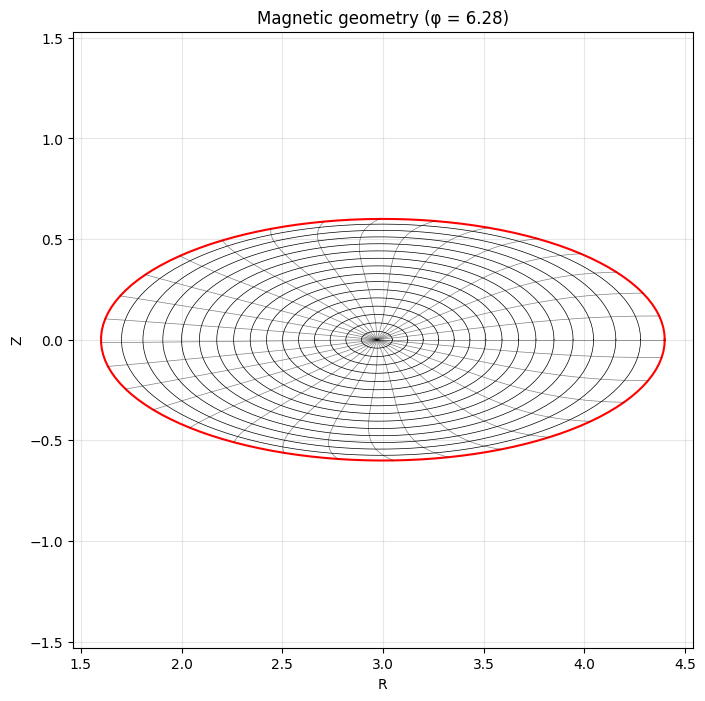

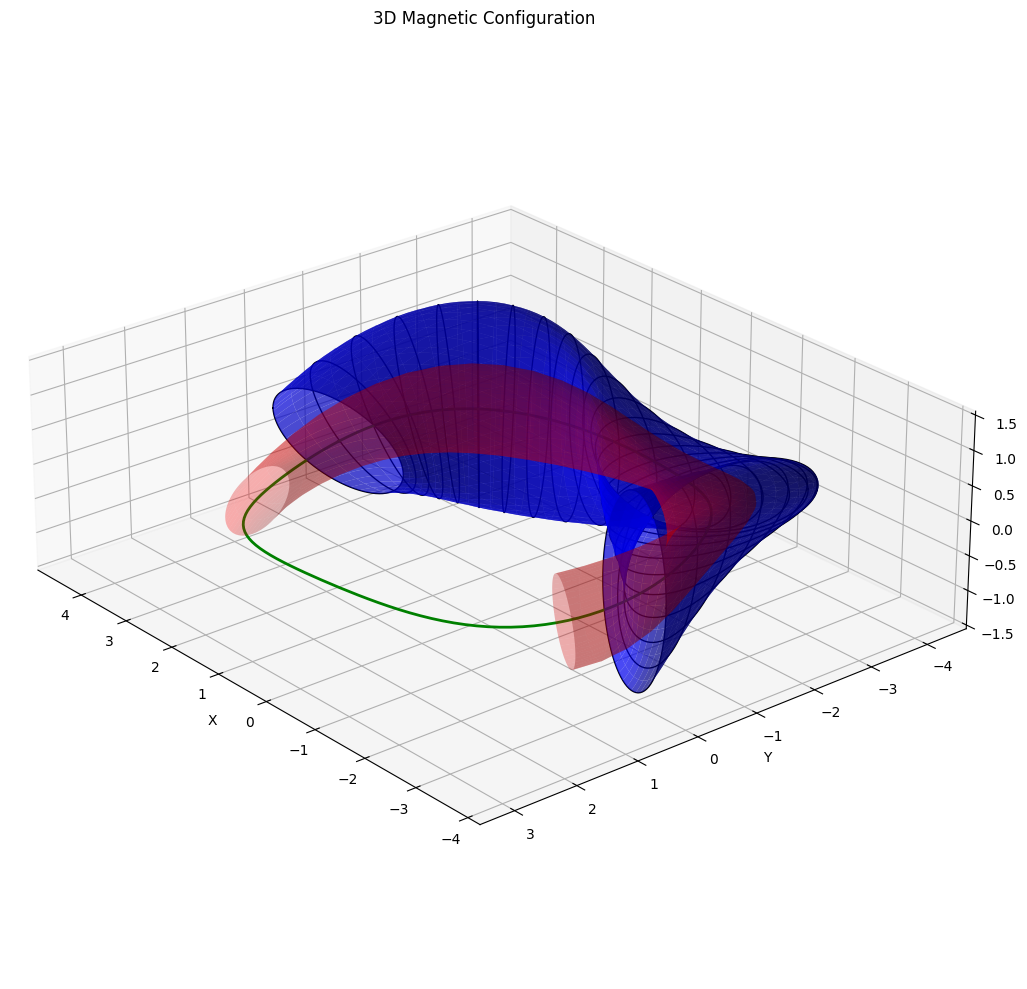

In [6]:
# Evaluate quantities on a 3D grid for visualization
# Use a single field period for visualization
gvecmc_stellarator.plot_geometry()
gvecmc_stellarator.plot_3D()

### Load from Parameter File (.ini) ###

This example demonstrates how to initialize GVEC from a parameter file.


Running GVEC from parameter file: params_gvec_W7X.ini


WARNING /home/pkrah/develop/gysela_magnet_conf/venv/lib/python3.11/site-packages/gvec/core/run.py:852: UserWarning: Force tolerance was not reached! |force|: 2.28e-03, minimize_tol: 1.00e-08
  warnings.warn(



GVEC finished after   5.9 seconds  using 100 iterations (totalIter = 100000)  with |force| = 2.28e-03 (minimize_tol = 1.00e-08) 
GVEC run successful


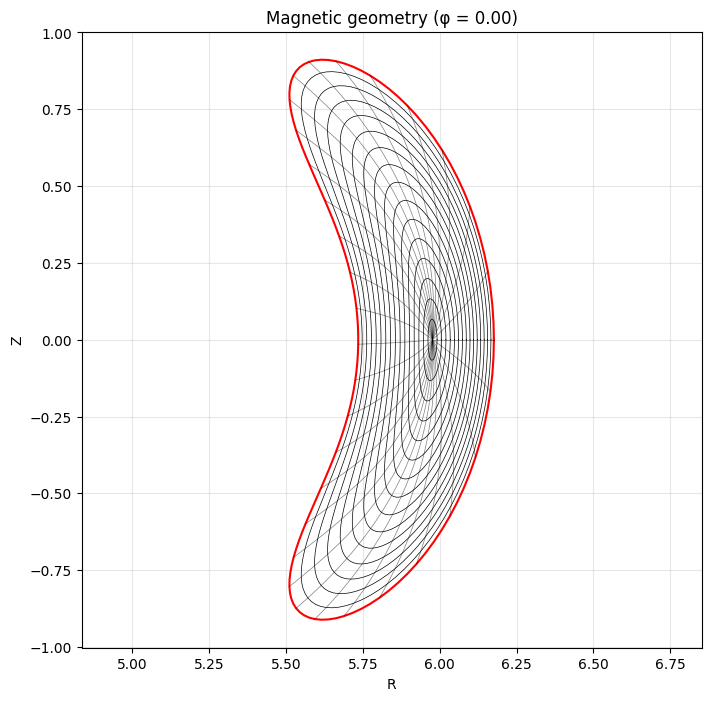

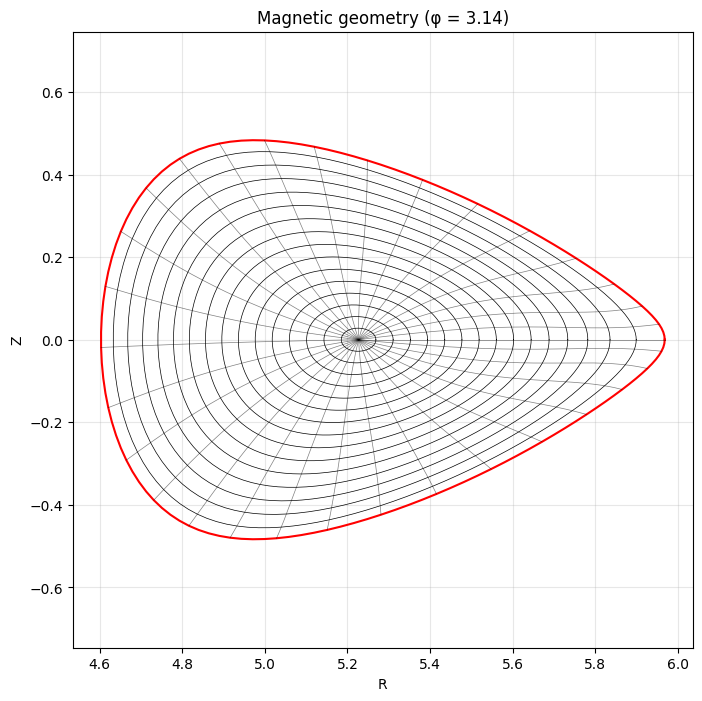

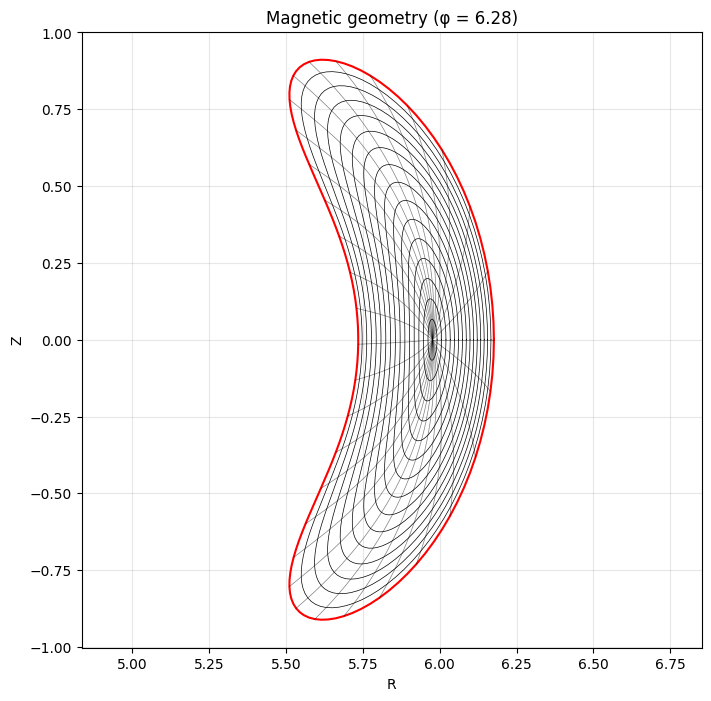

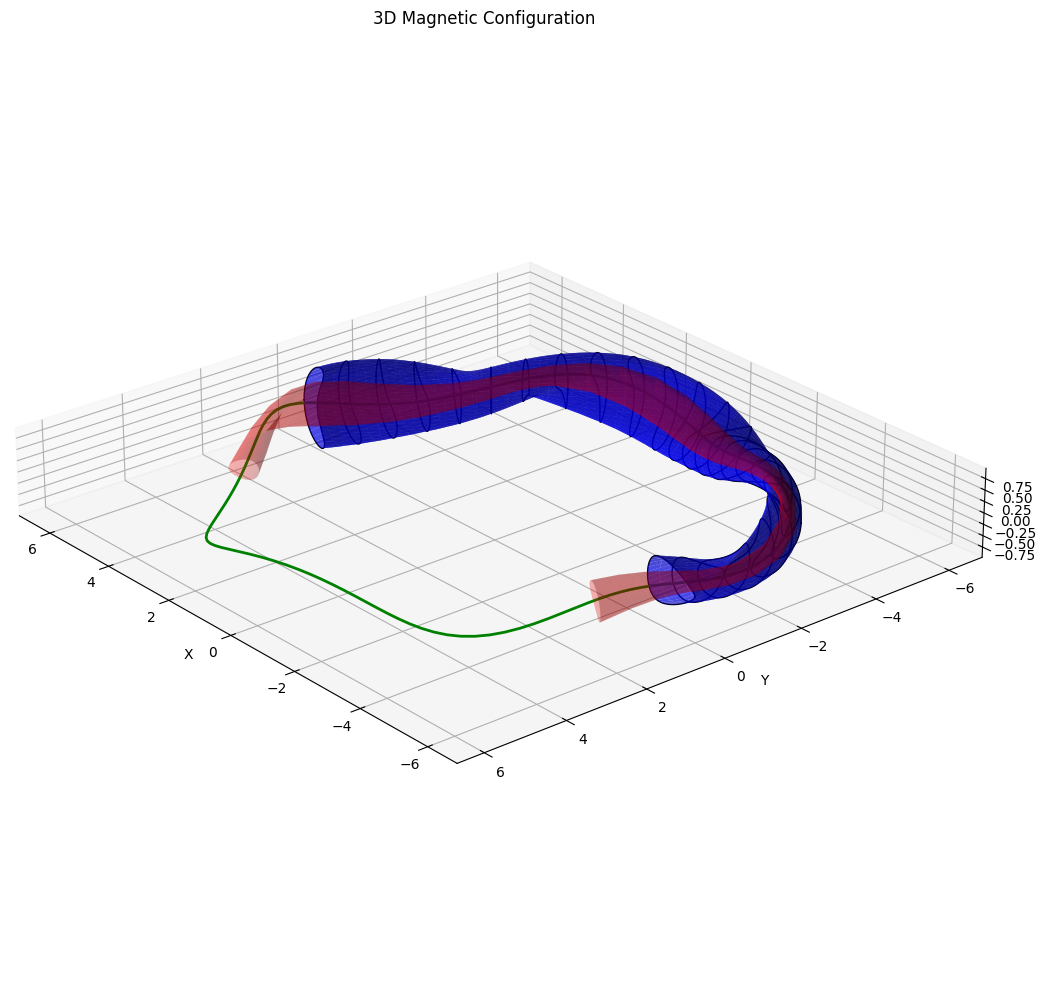

In [2]:
# Initialize GVEC from a parameter .ini file
gvecmc_from_file = GvecMagnetConfig.from_params("params_gvec_W7X.ini")

gvecmc_from_file.plot_geometry()

gvecmc_from_file.plot_3D()

# Save the configuration to file

In [ ]:
gvecmc_from_file.to_hdf5('mag_equi_W7X.h5')